In [1]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import scipy as sp
import astropy as ap
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.coordinates.representation as r
import astropy.units as u
%matplotlib inline

# Rotation Matrices
The rotation matrices for all streams are located in one file with 10 columns, 1 for stream name and 1 for each element of the matrix.  Here we import the file, and extract and format the rotation matrix for the ATLAS stream.

In [2]:
# Rotation matrix folder location and filename
cwd_path = pathlib.Path.cwd()
rot_mat_path = cwd_path / 'Rotation Matrices'

rot_mat_filename = 'rotation_matrices.fits'

In [3]:
# Import all rotation matrices
rot_mats = fits.getdata(rot_mat_path / rot_mat_filename, header=False)
# Select individual stream rotation matrix
def select_rot_mat(stream, rot_mats):
    selection_from_table = rot_mats['Stream'] == stream
    return_mat = np.zeros((3,3))
    column_mat = np.empty((3,3), dtype=object)
    for i in range(3):
        for j in range(3):
            return_mat[i][j] = float(rot_mats['R%d%d'%(i+1,j+1)][selection_from_table])
            column_mat[i][j] = 'R%d%d'%(i+1,j+1)
    return return_mat, column_mat

print('ATLAS rotation matrix:')
atlas_rot_mat, column_mat = select_rot_mat('ATLAS', rot_mats)
print(atlas_rot_mat)
print('Corresponding columns:')
print(column_mat)

ATLAS rotation matrix:
[[ 0.83697865  0.29481904 -0.4610298 ]
 [ 0.51616778 -0.70514011  0.4861566 ]
 [ 0.18176238  0.64487142  0.74236331]]
Corresponding columns:
[['R11' 'R12' 'R13']
 ['R21' 'R22' 'R23']
 ['R31' 'R32' 'R33']]


# Cubic Splines
Each type of cubic spline fit is stored in a separate file containing all the nodes for each stream.  There are 5 columns in each file, 1 for the stream the node belongs to, and 4 for the $\phi_1$ position, mean, and $16^{th}$ and $84^{th}$ percentiles of the node. 

In [4]:
# Cubic spline folder location and filenames
cwd_path = pathlib.Path.cwd()
cubic_splines_path = cwd_path / 'Cubic Splines'

spline_nodes_dist_mod_filename = 'spline_nodes_dist_mod.fits'
spline_nodes_intensity_filename = 'spline_nodes_intensity.fits'
spline_nodes_phi_2_filename = 'spline_nodes_phi_2.fits'
spline_nodes_sigma_filename = 'spline_nodes_sigma.fits'

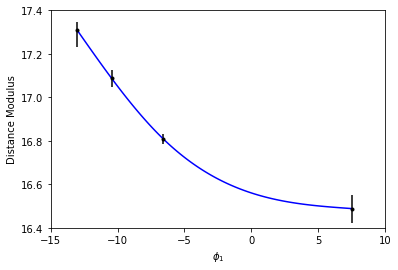

In [5]:
# Selecting the ATLAS distance modulus spline nodes
dist_mod_file = fits.getdata(cubic_splines_path / spline_nodes_dist_mod_filename, header=False)
dist_mod_atlas_selection = dist_mod_file['stream'] == 'atlas'
atlas_dist_mod_nodes = dist_mod_file[dist_mod_atlas_selection]

# Create the natural cubic spline for ATLAS
atlas_dist_mod_spline = interpolate.CubicSpline(atlas_dist_mod_nodes['phi1'], atlas_dist_mod_nodes['mean'], bc_type='natural')

# Calculate the positive and negative errors to plot using errorbar
atlas_dist_mod_errors = [atlas_dist_mod_nodes['mean'] - atlas_dist_mod_nodes['16th'], \
                        atlas_dist_mod_nodes['84th'] - atlas_dist_mod_nodes['mean']]

# Plot the nodes with error bars and the full cubic spline with median values
plt.errorbar(atlas_dist_mod_nodes['phi1'], atlas_dist_mod_nodes['mean'], atlas_dist_mod_errors, c='k', fmt='.')
sample_phi_1 = np.linspace(atlas_dist_mod_nodes['phi1'][0], atlas_dist_mod_nodes['phi1'][-1], 100)
plt.plot(sample_phi_1, atlas_dist_mod_spline(sample_phi_1), c='b')
plt.xlabel('$\phi_1$')
plt.ylabel('Distance Modulus')
plt.xlim([-15, 10])
plt.ylim([16.4, 17.4])
plt.show()

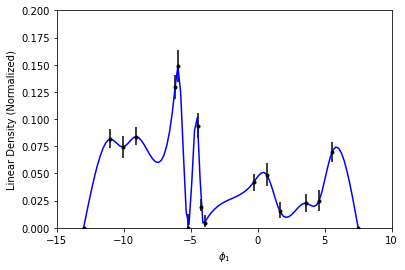

In [7]:
# Selecting the ATLAS linear density spline nodes
intensity_file = fits.getdata(cubic_splines_path / spline_nodes_intensity_filename, header=False)
intensity_atlas_selection = intensity_file['stream'] == 'atlas'
atlas_intensity_nodes = intensity_file[intensity_atlas_selection]

# Create the natural cubic spline for ATLAS
atlas_intensity_spline = interpolate.CubicSpline(atlas_intensity_nodes['phi1'], atlas_intensity_nodes['mean'], bc_type='natural')

# Calculate the positive and negative errors to plot using errorbar
atlas_intensity_errors = [(atlas_intensity_nodes['mean'] - atlas_intensity_nodes['16th']), \
                        (atlas_intensity_nodes['84th'] - atlas_intensity_nodes['mean'])]

# Plot the nodes with error bars and the full cubic spline with median values
plt.errorbar(atlas_intensity_nodes['phi1'], atlas_intensity_nodes['mean'], atlas_intensity_errors, c='k', fmt='.')
sample_phi_1 = np.linspace(atlas_intensity_nodes['phi1'][0], atlas_intensity_nodes['phi1'][-1], 100)
plt.plot(sample_phi_1, atlas_intensity_spline(sample_phi_1), c='b')
plt.xlabel('$\phi_1$')
plt.ylabel('Linear Density (Normalized)')
plt.xlim([-15, 10])
plt.ylim([0, 0.20])
plt.show()

In [8]:
# Selecting the ATLAS phi 2 spline nodes
phi_2_file = fits.getdata(cubic_splines_path / spline_nodes_phi_2_filename, header=False)
phi_2_atlas_selection = phi_2_file['stream'] == 'atlas'
atlas_phi_2_nodes = phi_2_file[phi_2_atlas_selection]

# Create the natural cubic spline for ATLAS
atlas_phi_2_spline = interpolate.CubicSpline(atlas_phi_2_nodes['phi1'], atlas_phi_2_nodes['mean'], bc_type='natural')

In [9]:
# Selecting the ATLAS width/sigma spline nodes
sigma_file = fits.getdata(cubic_splines_path / spline_nodes_sigma_filename, header=False)
sigma_atlas_selection = sigma_file['stream'] == 'atlas'
atlas_sigma_nodes = sigma_file[sigma_atlas_selection]

# Create the natural cubic spline for ATLAS
atlas_sigma_spline = interpolate.CubicSpline(atlas_sigma_nodes['phi1'], atlas_sigma_nodes['mean'], bc_type='natural')

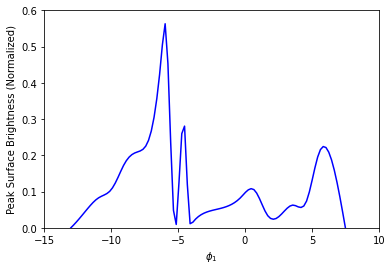

In [10]:
# Calculate and plot peak surface brightness, using the linear density and width of the stream
sample_phi_1 = np.linspace(atlas_intensity_nodes['phi1'][0], atlas_intensity_nodes['phi1'][-1], 100)
peak_surface_brightness = atlas_intensity_spline(sample_phi_1) / (np.sqrt(2.0*np.pi) * atlas_sigma_spline(sample_phi_1))
plt.plot(sample_phi_1, peak_surface_brightness, c='b')
plt.xlabel('$\phi_1$')
plt.ylabel('Peak Surface Brightness (Normalized)')
plt.xlim([-15, 10])
plt.ylim([0, 0.60])
plt.show()

# Stream Tracks
We include a separate file for each stream with 100 sample points along their stream track.  These points are evenly spaced in $\phi_1$ and follow the fit $\phi_2$ spline, but start/end at the endpoints of the stream rather than the full $\phi_1$ range of the spline.  There are 4 columns in each file, 2 for the stream track in the stream aligned $\phi_1$ and $\phi_2$ coordinates, and 2 for the stream track in RA and Dec coordinates.

In [11]:
# Stream tracks folder location and sample filename (for ATLAS)
cwd_path = pathlib.Path.cwd()
stream_tracks_path = cwd_path / 'Stream Tracks'

atlas_stream_track_filename = 'stream_track_atlas.fits'

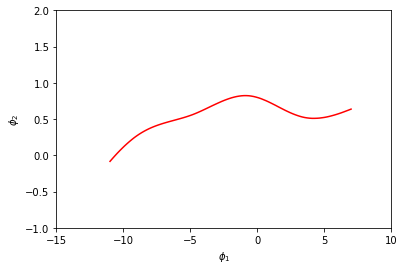

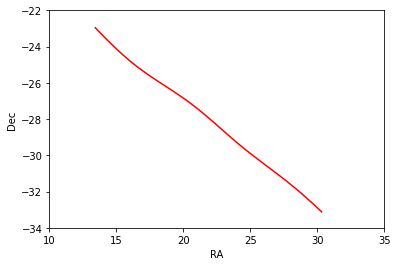

In [12]:
# ATLAS stream track
atlas_track = fits.getdata(stream_tracks_path / atlas_stream_track_filename, header=False)

plt.plot(atlas_track['phi1'], atlas_track['phi2'], c='r')
plt.xlabel('$\phi_1$')
plt.ylabel('$\phi_2$')
plt.xlim([-15, 10])
plt.ylim([-1, 2])
plt.show()

plt.plot(atlas_track['RA'], atlas_track['Dec'], c='r')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim([10, 35])
plt.ylim([-34, -22])
plt.show()